In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 3-6. PyTorch로 구현해보는 손실 함수 (Loss Function)

In [1]:
import numpy as np 
import torch 
from torch import nn 
import matplotlib.pyplot as plt 
import os 
import warnings

warnings.filterwarnings("ignore")

```
# Pseudo Code
# initialize loss function
loss_fn = nn.MSELoss(reduction="mean")

for batch in dataloader:
    input, ground_truth = batch
    optimizer.zero_grad()
    predicted = model(input)  # forward pass
    
    # compute loss
    loss = loss_fn(predicted, ground_truth)  
    
    loss.backward()  # backward pass
    optimizer.step()  # step function
    
```

# Utility function

In [2]:
# Convert integer gt label to one hot gt label
def convert_integer2onehot(ground_truth_integer, n_class=10):
    batch_size=len(ground_truth_integer)
    ground_truth_one_hot = torch.zeros((batch_size, n_class))
    ground_truth_one_hot[torch.arange(batch_size), ground_truth_integer] = 1
    return ground_truth_one_hot

In [4]:
convert_integer2onehot([[1]], 10)  # index label을 onhot label로 변환!

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Loss function for regression

1. MSE (```nn.MSELoss```)
2. MAE (```nn.L1Loss```)
3. Huber (```nn.HuberLoss```)

## Generating regression data

In [3]:
batch_size = 16
def generate_regression(batch_size=16):
    return torch.rand(batch_size), torch.rand(batch_size) 

In [4]:
predicted, ground_truth = generate_regression()

In [5]:
print("predicted.shape == ", predicted.shape, "ground_truth.shape == ", ground_truth.shape)

predicted.shape ==  torch.Size([16]) ground_truth.shape ==  torch.Size([16])


## MSE loss

In [6]:
loss = nn.MSELoss(reduction="mean")
loss(predicted, ground_truth)  # shape==(1,)

tensor(0.2660)

### ```reduction="mean"``` vs. ```reduction="none"```

```reduction="mean"```일 경우, mini-batch의 sample들에 대한 loss의 평균을 냅니다. \
참고로, ```loss.backward()```을 하기 위해서는 scalar값에 대해서만 backward()가 가능합니다. \
따라서 학습할때는 ```reduction="mean"```으로 둡니다.

하지만 만약에 (mini-batch 단위가 아닌) 각 sample에 대한 loss을 따로 따로 보고 싶다면 ```reduction="none"```으로 각 sample에 대한 loss을 개별적으로 확인할 수 있습니다.

In [7]:
loss = nn.MSELoss(reduction="none")
loss(predicted, ground_truth)  # shape==(batch_size,)

tensor([6.7388e-01, 4.9701e-01, 2.0252e-02, 3.5645e-02, 6.8667e-01, 3.8174e-01,
        1.6669e-04, 2.4708e-02, 4.4655e-01, 5.1532e-03, 2.4604e-03, 4.9244e-01,
        2.0528e-03, 4.7684e-01, 4.6748e-01, 4.2547e-02])

In [8]:
torch.mean(loss(predicted, ground_truth))  # reduction="mean"의 결과와 같다!

tensor(0.2660)

## MAE Loss

In [9]:
loss = nn.L1Loss(reduction="mean")
loss(predicted, ground_truth)  # shape==(1,)

tensor(0.4119)

## Huber Loss

In [10]:
loss = nn.HuberLoss(reduction="mean")
loss(predicted, ground_truth)  # shape==(1,)

tensor(0.1330)

## Plot으로 각 Regression Loss (MSE vs. MAE vs. Huber) 을 비교해보자

In [11]:
N=100
y_pred = np.linspace(-3, 3, N)
y_pred = torch.Tensor(y_pred)
y_true = torch.zeros(N)

In [12]:
l1_loss_fn = nn.L1Loss(reduction="none")
l1_list = l1_loss_fn(y_pred, y_true)

In [13]:
mse_loss_fn = nn.MSELoss(reduction="none")
mse_list = mse_loss_fn(y_pred, y_true)

In [14]:
huber_loss_fn = nn.HuberLoss(reduction="none")
huber_list = huber_loss_fn(y_pred, y_true)

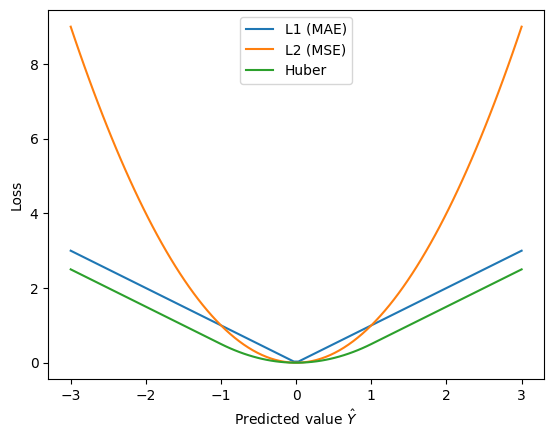

In [15]:
os.makedirs('figures', exist_ok=True)

plt.figure()
plt.plot(y_pred, l1_list.numpy(), label='L1 (MAE)')
plt.plot(y_pred, mse_list.numpy(), label='L2 (MSE)')
plt.plot(y_pred, huber_list.numpy(), label='Huber')
plt.legend()
plt.xlabel(r"Predicted value $\hat{Y}$")
plt.ylabel('Loss')
plt.savefig('figures/regression_loss_fn.png', dpi=300)

# Loss function for classification


1. Cross Entropy Loss \
    1-1. ```nn.CrossEntropyLoss``` \
    1-2. ```nn.BCELoss``` \
    1-3. ```nn.BCEWithLogitsLoss```
2. L1 Loss (```nn.L1Loss```)
3. KL Divergence (```nn.KLDivLoss```)

## Generating Classification data


- ```generate_classification``` 함수는 integer class label 형태의 ground truth을 생성합니다. ```(batch_size, )```
- ```generate_onehot```함수는 onehot 형태의 ground truth을 생성한다. ```(batch_size, N_class)```
- ```predicted label```은 ```(batch_size, n_class)```의 형태로 각 class에 해당될 예측된 확률값을 의미합니다.





In [16]:
batch_size = 16
n_class=10
def generate_classification(batch_size=16, n_class=10):
    pred = torch.nn.Softmax()(torch.rand(batch_size, n_class))
    gt = torch.argmax(torch.rand(batch_size, n_class),dim=1)
    return pred, gt


In [17]:
batch_size = 16
n_class=10

def generate_onehot(batch_size=16, n_class=10):
    pred = torch.nn.Softmax()(torch.rand(batch_size, n_class))
    gt = torch.rand(batch_size, n_class)
    gt = torch.tensor(gt == torch.max(gt, dim=1, keepdim=True)[0]).float()  # convert to onehot
    return pred, gt


In [18]:
predicted, ground_truth = generate_classification()

In [19]:
predicted.shape  # (batch_size, n_class)

torch.Size([16, 10])

In [20]:
ground_truth.shape  # (batch_size, )

torch.Size([16])

## Cross Entropy Loss

### ```nn.CrossEntropyLoss```

**참고로**

- CrossEntropyLoss에서는 input (예측값)보다 target (실제값)의 차원이 하나 더 적어야 한다.
    - 예를 들면, input.shape == (batch_size, number_of_class) 이고 target.shape == (batch_size, )
- input은 0~1사이의 값으로 normalize되어야 한다.
- target은 long type (integer)의 tensor여야 한다.

In [21]:
loss = nn.CrossEntropyLoss(reduction="mean")

In [22]:
print("predicted.shape == ", predicted.shape, "ground_truth.shape == ", ground_truth.shape)

predicted.shape ==  torch.Size([16, 10]) ground_truth.shape ==  torch.Size([16])


In [23]:
loss(predicted, ground_truth)

tensor(2.2941)

In [24]:
# nn.CrossEntropyLoss 직접 구현해본 버전
def CE_loss(predicted, ground_truth):
    # convert ground_truth into 
    loss = 0.
    exp_pred = torch.exp(predicted)  # take exponential
    for batch_i in range(len(predicted)):
        
        for j in range(len(predicted[0])):
            if j == ground_truth[batch_i]:
                loss = loss + torch.log( exp_pred[batch_i][j] / torch.sum(exp_pred, axis=1)[batch_i] )
    return -loss / len(predicted)

In [25]:
CE_loss(predicted, ground_truth)

tensor(2.2941)

### ```nn.BCELoss```

**참고로**

- BCELoss에서는 input (예측값)과 target (실제값)과 shape이 같아야합니다.
- input은 0~1 사이의 값으로 normalize되어야 합니다.
- target도 0~1 사이의 값이어야 하고 float type이어야 합니다.

Index label type의 Ground truth을 nn.BCELoss에 사용하면 에러가 뜹니다. \
왜냐하면,
- Index label type의 ground truth은 long type이고
- input과 target의 shape이 동일하지 않기 때문입니다.


In [26]:
loss = nn.BCELoss(reduction="mean")

In [27]:
print("predicted.shape == ", predicted.shape, "ground_truth.shape == ", ground_truth.shape)

predicted.shape ==  torch.Size([16, 10]) ground_truth.shape ==  torch.Size([16])


In [28]:
loss(predicted, ground_truth)  # error

ValueError: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 10])) is deprecated. Please ensure they have the same size.

For probability ground truth (in logits)

In [29]:
predicted, ground_truth = generate_onehot()

In [30]:
print("predicted.shape == ", predicted.shape, "ground_truth.shape == ", ground_truth.shape)

predicted.shape ==  torch.Size([16, 10]) ground_truth.shape ==  torch.Size([16, 10])


In [31]:
loss(predicted, ground_truth)

tensor(0.3402)

In [32]:
# nn.BCELoss을 직접 구현해본 버전

def BCE_loss(predicted, ground_truth):
    loss = 0.
    for batch_i in range(len(predicted)):
        for j in range(len(predicted[0])):
            loss = loss \
            + ground_truth[batch_i][j] * torch.log(predicted[batch_i][j]) \
            + (1 - ground_truth[batch_i][j]) * torch.log(1 - predicted[batch_i][j])
            
    return - loss / (len(predicted) * len(predicted[0]))
            
            

In [33]:
BCE_loss(predicted, ground_truth)

tensor(0.3402)

### ```nn.BCEWithLogitsLoss```

```nn.BCEWithLogitsLoss```은 ***Sigmoid layer + nn.BCELoss***입니다!

일반적으로 NN의 마지막 layer을 Sigmoid Layer로 둬서 모델의 출력값이 0~1사이의 값으로 만들어줍니다.

하지만 Sigmoid와 BCELoss을 각각 따로 forward pass했을시 numerical instability로 인해서 계산이 조금 부정확해질 수 있습니다.

```BCEWithLogitsLoss```은 Sigmoid + BCELoss에 대해서 numerically stable한 버전입니다.

*** 중요한 포인트 *** \
따라서, BCEWithLogitsLoss을 사용할 경우 NN은 Sigmoid layer을 생략해야 합니다!

In [34]:
predicted, ground_truth = generate_onehot()

In [35]:
predicted = 10 * predicted  # 10을 곱해서 0~10 사이의 값으로 만들어보자

**BCEWithLogitsLoss의 결과**

In [36]:
loss = nn.BCEWithLogitsLoss(reduction="mean")

In [37]:
loss(predicted, ground_truth)

tensor(1.2233)

**Sigmoid layer + nn.BCELoss의 값과 비교해봅시다**

In [38]:
loss = nn.BCELoss(reduction="mean")

In [39]:
loss(torch.nn.Sigmoid()(predicted), ground_truth)

tensor(1.2233)

Sigmoid Layer + BCELoss의 결과와 BCEWithLogitsLoss의 결과가 같은것을 확인할 수 있습니다!

## L1 Loss

BCELoss와 마찬가지로 GT이 onehot일 경우에 대해서 사용할 수 있습니다.

In [40]:
predicted, ground_truth = generate_onehot()

In [41]:
loss = nn.L1Loss(reduction="mean")

In [42]:
loss(predicted, ground_truth)

tensor(0.1787)

## KL Divergence Loss

BCELoss와 마찬가지로 GT이 onehot일 경우에 대해서 사용할 수 있습니다.

In [43]:
predicted, ground_truth = generate_onehot()  # BCELoss와 마찬가지로 GT이 onehot일 경우

In [44]:
loss = nn.KLDivLoss(reduction="mean")

In [45]:
loss(predicted, ground_truth)  # error

tensor(-0.0096)

## Plot으로 각 Classification Loss (CE Loss vs. L1 Loss vs. KL Div Loss) 비교하기


In [55]:
def ce_loss(y, y_true):
    return -(y_true * np.log(y) + (1 - y_true)*np.log(1 - y))
    
    
def l1_loss(y, y_true):
    return np.abs(y - y_true)

def kl_loss(y, y_true):
    return (y_true * np.log (y_true) - y_true * np.log(y) + (1-y_true)*np.log(1-y_true)-(1-y_true)*np.log(1- y))



In [57]:
def plot_graph(y_true=0.99):
    x_values = np.linspace(0.01, 0.99, 50)

    ce = [ce_loss(i, y_true) for i in x_values]
    l1 = [l1_loss(i, y_true) for i in x_values]
    kl = [kl_loss(i, y_true) for i in x_values]

    plt.figure()
    plt.plot(x_values, ce, label="Cross Entropy Loss")
    plt.plot(x_values, l1, label="L1 Loss")
    plt.plot(x_values, kl, label=r"KL divergence Loss")
    plt.xlabel(r"Predicted Probability $\hat{Y}$")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("y true = %.2f" % y_true)
    plt.savefig(f"figures/loss_class_%.2f.png" % y_true, format="png", dpi=600)
    plt.show()


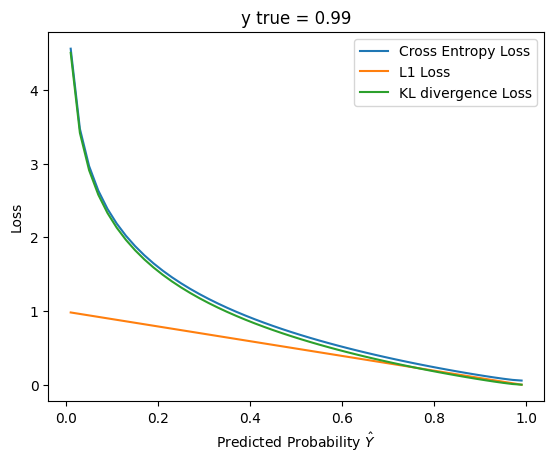

In [58]:
plot_graph(0.99)

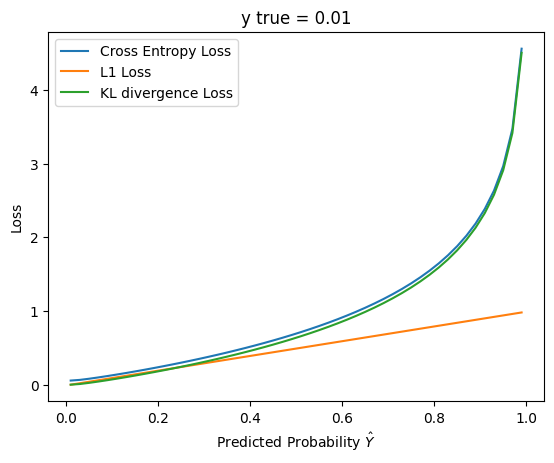

In [59]:
plot_graph(0.01)

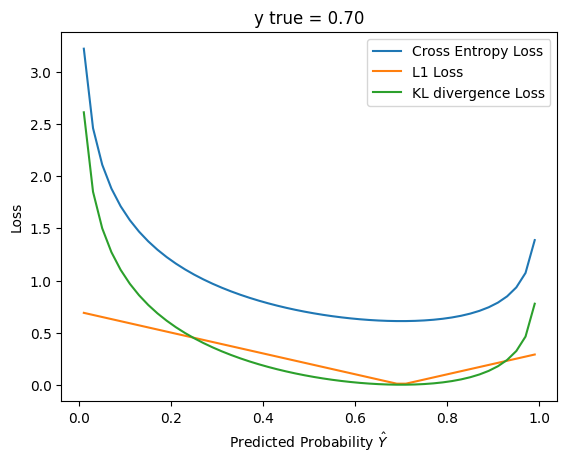

In [60]:
plot_graph(0.7)

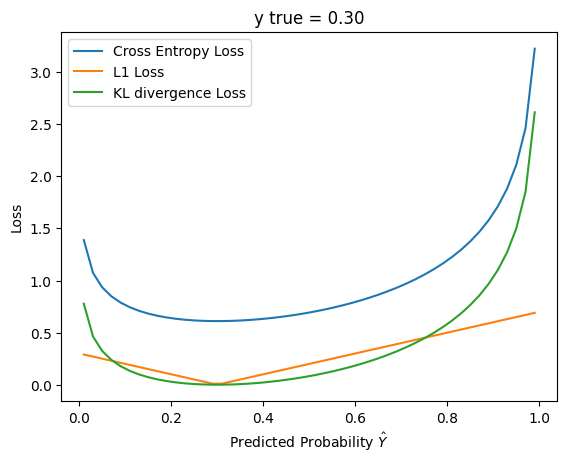

In [61]:
plot_graph(0.3)